# 少量样本 QLoRA Finetune Qwen-7b DEMO for Align Tech

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import transformers 
print(transformers.__version__)

4.34.0


In [3]:
import peft 
print(peft.__version__)

0.5.0


In [4]:
import accelerate 
print(accelerate.__version__)

0.23.0


In [5]:
import torchkeras
print(torchkeras.__version__)

3.9.4


In [6]:
!pip show bitsandbytes


Name: bitsandbytes
Version: 0.41.1
Summary: k-bit optimizers and matrix multiplication routines.
Home-page: https://github.com/TimDettmers/bitsandbytes
Author: Tim Dettmers
Author-email: dettmers@cs.washington.edu
License: MIT
Location: /home/ecs-assist-user/micromamba/envs/qwen/lib/python3.10/site-packages
Requires: 
Required-by: 


## 〇，预训练模型

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


#使用QLoRA引入的 NF4量化数据类型以节约显存
model_name_or_path ='/home/ecs-assist-user/llm/Qwen-7B-Chat'  #远程：'Qwen/Qwen-7b-Chat'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


The model is automatically converting to fp16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
from torchkeras.chat import ChatLLM 
llm = ChatLLM(model,tokenizer)

register magic %%chat sucessed ...


In [10]:
#llm.chat(messages=llm.build_messages(query='Align产品之间的转换有哪些规定?'))

In [11]:
%%chat
什么是智能力引导功能?

智能力引导功能是一种人工智能技术，它可以帮助用户更好地理解和使用人工智能系统。它通过使用自然语言处理、机器学习和深度学习等技术，帮助用户更好地理解人工智能系统的功能和操作方式，并且可以提供有用的建议和指导，以帮助用户更有效地使用人工智能系统。


## 一，准备数据

### 1，导入样本

In [12]:
data=[
  {
    "question": [
      "什么是智能力引导功能?",
      "智能力引导功能的作用是什么?",
      "引入智能力引导功能的目的是什么?"
    ],
    "answer": "智能力引导功能是引导并提供正畸牙齿移动所需的生物力学力量的功能。"
  },
  {
    "question": [
      "传统附件和优化附件有什么区别?",
      "请说明传统附件和优化附件的不同之处",
      "优化附件与传统附件相比有哪些特点?"
    ],
    "answer": "附件本质上是附着在牙齿表面上的材料。优化附件包含用于提供必要矫治力系统的先进技术,对每颗牙齿进行虚拟建模,更精确定位以提供必要的矫治力。与传统附件不同,优化附件由Treat软件根据所需移动自动放置。"
  },
  {
    "question": [
      "为什么优化附件的形状与矫治器的形状不同?",
      "优化附件形状与对应矫治器形状不一致的原因是什么?",
      "优化附件与矫治器形状不同的考虑因素有哪些?"
    ],
    "answer": "优化附件的形状与矫治器形状不同。软件通过两个因素确定矫治器形状:主动面之间无间隙以产生牙齿移动所需矫治力;非主动面设计间隙以避免不必要的矫治力。"
  },
  {
    "question": [
      "使用优化控根附件时功能面的正确方向是?",
      "优化控根附件的功能面应该朝向哪个方向?",
      "优化控根附件的功能面正确方向指的是什么?"
    ],
    "answer": "这些优化附件用于控制根倾斜度。驱动力来自最靠近阻抗中心的附件或单个控根附件的SmartStage。远离阻抗中心的附件提供第二个力以产生反力矩用于倾斜控制。"
  },
  {
    "question": [
      "放置优化控根附件的上颌侧切牙,矫治器在切端部分不贴合是否正常?",
      "对于放置了优化控根附件的上颌侧切牙,矫治器在切端有间隙正常吗?",
      "优化控根附件的上颌侧切牙矫治器切端间隙是预期的现象吗?"
    ],
    "answer": "是的。为产生预期的矫治力系统,我们在矫治器与牙齿切缘近中远中留有称为矫治器间隙的间隙,以避免不必要的接触和矫治力。"
  },
  {
    "question": [
      "为什么前磨牙在某些方案见到两个优化控根附件,而其他只见一个?",
      "前磨牙优化控根附件为什么有的方案是两个,有的方案只有一个?",
      "什么情况下前磨牙会用两个优化控根附件,什么情况下只用一个?"
    ],
    "answer": "当牙齿空间足够时会放两个附件在颊面;当冠高太短时会放一个附件在颊面。"
  }, {
    "question": [
      "中切牙没有压力点和矫治器间隙的原因是什么?",
      "为什么中切牙上没有压力点和矫治器空间?",
      "中切牙没有压力点和矫治器间隙的考虑因素是什么?"
    ],
    "answer": "中切牙是较大的牙齿,并且通常具有足够的牙齿表面以放置两个控根附件,因此不需要压力点和矫治器间隙。"
  }]

print(data)

[{'question': ['什么是智能力引导功能?', '智能力引导功能的作用是什么?', '引入智能力引导功能的目的是什么?'], 'answer': '智能力引导功能是引导并提供正畸牙齿移动所需的生物力学力量的功能。'}, {'question': ['传统附件和优化附件有什么区别?', '请说明传统附件和优化附件的不同之处', '优化附件与传统附件相比有哪些特点?'], 'answer': '附件本质上是附着在牙齿表面上的材料。优化附件包含用于提供必要矫治力系统的先进技术,对每颗牙齿进行虚拟建模,更精确定位以提供必要的矫治力。与传统附件不同,优化附件由Treat软件根据所需移动自动放置。'}, {'question': ['为什么优化附件的形状与矫治器的形状不同?', '优化附件形状与对应矫治器形状不一致的原因是什么?', '优化附件与矫治器形状不同的考虑因素有哪些?'], 'answer': '优化附件的形状与矫治器形状不同。软件通过两个因素确定矫治器形状:主动面之间无间隙以产生牙齿移动所需矫治力;非主动面设计间隙以避免不必要的矫治力。'}, {'question': ['使用优化控根附件时功能面的正确方向是?', '优化控根附件的功能面应该朝向哪个方向?', '优化控根附件的功能面正确方向指的是什么?'], 'answer': '这些优化附件用于控制根倾斜度。驱动力来自最靠近阻抗中心的附件或单个控根附件的SmartStage。远离阻抗中心的附件提供第二个力以产生反力矩用于倾斜控制。'}, {'question': ['放置优化控根附件的上颌侧切牙,矫治器在切端部分不贴合是否正常?', '对于放置了优化控根附件的上颌侧切牙,矫治器在切端有间隙正常吗?', '优化控根附件的上颌侧切牙矫治器切端间隙是预期的现象吗?'], 'answer': '是的。为产生预期的矫治力系统,我们在矫治器与牙齿切缘近中远中留有称为矫治器间隙的间隙,以避免不必要的接触和矫治力。'}, {'question': ['为什么前磨牙在某些方案见到两个优化控根附件,而其他只见一个?', '前磨牙优化控根附件为什么有的方案是两个,有的方案只有一个?', '什么情况下前磨牙会用两个优化控根附件,什么情况下只用一个?'], 'answer': '当牙齿空间足够时会放两个附件在颊面;当冠高太短时

### 2，做数据集

In [13]:
from torch.utils.data import Dataset,DataLoader 
from copy import deepcopy
import random
class MyDataset(Dataset):

    def __init__(self,data
                ):
        self.data = data
        self.size = len(data)
        self.index_list = list(range(self.size))
        
        
    def get_messages(self):
        select = random.choice
        messages,history = [],[]
        for t in self.data:
            history.append((select(t["question"]),t["answer"]))
            
        for prompt,response in history:
            pair = [{"role": "user", "content": prompt},
                {"role": "assistant", "content": response}]
            messages.extend(pair)
        return messages 
        
    def __len__(self):
        return self.size
        
    def get(self,index):
        idx = self.index_list[index]
        messages = self.get_messages()
        return messages

    
    def __getitem__(self,index):
        messages = self.get(index)
        input_ids, labels = llm.build_inputs_labels(messages,multi_rounds=True) #支持多轮
        return {'input_ids':input_ids,'labels':labels}
    

In [14]:
#slider=int(round((len(data)*0.7),0))
#ds_train =  MyDataset(data[:slider])
#ds_val = MyDataset(data[slider:])
ds_train=ds_val= MyDataset(data)

In [15]:
ds_train.get_messages()

[{'role': 'user', 'content': '智能力引导功能的作用是什么?'},
 {'role': 'assistant', 'content': '智能力引导功能是引导并提供正畸牙齿移动所需的生物力学力量的功能。'},
 {'role': 'user', 'content': '请说明传统附件和优化附件的不同之处'},
 {'role': 'assistant',
  'content': '附件本质上是附着在牙齿表面上的材料。优化附件包含用于提供必要矫治力系统的先进技术,对每颗牙齿进行虚拟建模,更精确定位以提供必要的矫治力。与传统附件不同,优化附件由Treat软件根据所需移动自动放置。'},
 {'role': 'user', 'content': '为什么优化附件的形状与矫治器的形状不同?'},
 {'role': 'assistant',
  'content': '优化附件的形状与矫治器形状不同。软件通过两个因素确定矫治器形状:主动面之间无间隙以产生牙齿移动所需矫治力;非主动面设计间隙以避免不必要的矫治力。'},
 {'role': 'user', 'content': '优化控根附件的功能面应该朝向哪个方向?'},
 {'role': 'assistant',
  'content': '这些优化附件用于控制根倾斜度。驱动力来自最靠近阻抗中心的附件或单个控根附件的SmartStage。远离阻抗中心的附件提供第二个力以产生反力矩用于倾斜控制。'},
 {'role': 'user', 'content': '优化控根附件的上颌侧切牙矫治器切端间隙是预期的现象吗?'},
 {'role': 'assistant',
  'content': '是的。为产生预期的矫治力系统,我们在矫治器与牙齿切缘近中远中留有称为矫治器间隙的间隙,以避免不必要的接触和矫治力。'},
 {'role': 'user', 'content': '前磨牙优化控根附件为什么有的方案是两个,有的方案只有一个?'},
 {'role': 'assistant', 'content': '当牙齿空间足够时会放两个附件在颊面;当冠高太短时会放一个附件在颊面。'},
 {'role': 'user', 'content': '为什么中切牙上没有压力点和矫治器空间?'},
 {'r

### 3，创建管道

In [16]:
#如果pad为None，需要处理一下
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.unk_token_id if tokenizer.unk_token_id is not None else tokenizer.eos_token_id
    

def data_collator(examples: list):
    
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [17]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=2,
                                       pin_memory=True,shuffle=False,
                                       collate_fn = data_collator)

dl_val = torch.utils.data.DataLoader(ds_val,batch_size=2,
                                    pin_memory=True,shuffle=False,
                                     collate_fn = data_collator)


In [18]:
for batch in dl_train:
    pass

In [19]:
#试跑一个batch
#out = model(**batch)

In [20]:
#out.loss 

In [21]:
#len(dl_train)

## 二，定义模型

下面我们将使用QLoRA(实际上用的是量化的AdaLoRA）算法来微调Baichuan-13b模型。

In [22]:
from peft import get_peft_config, get_peft_model, TaskType
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [23]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


In [24]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model)


In [25]:
lora_modules = find_all_linear_names(model)
print(lora_modules) 


['w2', 'c_proj', 'c_attn', 'w1']


In [26]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=16,
    lora_alpha=16, lora_dropout=0.08,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 26,838,912 || all params: 7,748,163,616 || trainable%: 0.34639062015388394


## 三，训练模型

In [27]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net.forward(**batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

#仅仅保存QLora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [28]:
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=6e-03,is_paged=True)  #'paged_adamw'
keras_model = KerasModel(peft_model,loss_fn =None,
        optimizer=optimizer) 

ckpt_path = 'qwen7b_multirounds'

In [29]:
keras_model.from_scratch=False

<<<<<< ⚡️ cuda is used >>>>>>


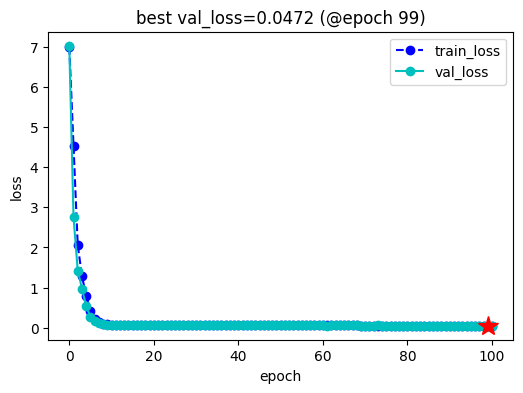

[2023-10-17 16:37:22,767] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


,epoch,train_loss,lr,val_loss
0,0,7.002328,0.000,7.031918
1,1,4.533229,0.006,2.756535
2,2,2.056239,0.006,1.424076
3,3,1.286152,0.006,0.975162
4,4,0.790883,0.006,0.526785
...,...,...,...,...
96,96,0.048665,0.006,0.049002
97,97,0.048523,0.006,0.048183
98,98,0.048040,0.006,0.048173
99,99,0.048184,0.006,0.047165


In [30]:
# keras_model.load_ckpt(ckpt_path) #支持加载微调后的权重继续训练(断点续训)
keras_model.fit(train_data = dl_train,
                val_data = dl_val, 
                epochs=100,patience=15,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path
               )

## 四，保存模型

为减少GPU压力，此处可重启kernel释放显存

In [31]:
import warnings 
warnings.filterwarnings('ignore')

In [32]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn
#使用QLoRA引入的 NF4量化数据类型以节约显存
model_name_or_path ='/home/ecs-assist-user/llm/Qwen-7B-Chat'
ckpt_path = 'qwen7b_multirounds'



tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


The model is automatically converting to fp16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [33]:
from peft import PeftModel

#可能需要5分钟左右
peft_model = PeftModel.from_pretrained(model, ckpt_path)
model_new = peft_model.merge_and_unload()


In [34]:
from transformers.generation.utils import GenerationConfig
model_new.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


In [35]:
save_path = '/home/ecs-assist-user/llm/finetuned/Qwen7B-align-tech'

In [36]:
tokenizer.save_pretrained(save_path)
model_new.save_pretrained(save_path)

In [37]:
!cp /home/ecs-assist-user/llm/Qwen-7B-Chat/*.py  qwen_torchkeras/

cp: target ‘qwen_torchkeras/’ is not a directory


In [38]:
!ls  /home/ecs-assist-user/llm/finetuned/Qwen7B-align-tech

config.json			  pytorch_model.bin.index.json
configuration_qwen.py		  qwen_generation_utils.py
cpp_kernels.py			  qwen.tiktoken
generation_config.json		  special_tokens_map.json
modeling_qwen.py		  tokenization_qwen.py
pytorch_model-00001-of-00002.bin  tokenizer_config.json
pytorch_model-00002-of-00002.bin


## 五，使用模型

为减少GPU压力，此处可再次重启kernel释放显存。

In [39]:

import warnings
warnings.filterwarnings('ignore')


In [40]:
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn
model_name_or_path =  save_path

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

inference_tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, use_fast=False, trust_remote_code=True)

inference_model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,device_map="auto", 
                trust_remote_code=True) 

inference_model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

我们测试一下微调后的效果。

In [41]:
from torchkeras.chat import ChatLLM 
llm = ChatLLM(inference_model,inference_tokenizer)

register magic %%chat sucessed ...


先用训练集中的一条数据中的三种不同的问法提问，原始训练数据如下：
```json
{
    "question": [
      "什么是智能力引导功能?",
      "智能力引导功能的作用是什么?",
      "引入智能力引导功能的目的是什么?"
    ],
    "answer": "智能力引导功能是引导并提供正畸牙齿移动所需的生物力学力量的功能。"
  }
```

In [42]:
%%chat
什么是智能力引导功能?

智能力引导功能是引导并提供正畸牙齿移动所需的生物力学力量的功能。


In [43]:
%%chat
智能力引导功能的作用是什么?

智能力引导功能是通过给予牙齿适当的矫治力来驱动牙齿移动。我们使用两种方法实现智能力引导: 电阻抗技术 and 附件技术。


In [44]:
%%chat
引入智能力引导功能的目的是什么?

引入智能力引导功能的目的是运用科学方法提供精确的矫治力。


In [45]:
%%chat
如何确定隐形矫治复杂性评估工具的可靠性？

该隐形矫治复杂性评估工具的可靠性已经通过临床实验进行验证。此外，该工具是根据大量的临床观察和专家意见进行开发的，旨在提供对患者牙齿状况的客观评估，并准确预测矫治过程。


同时问两个问题

```json
原始训练数据
{
    "question": [
      "为什么优化附件的形状与矫治器的形状不同?",
      "优化附件形状与对应矫治器形状不一致的原因是什么?",
      "优化附件与矫治器形状不同的考虑因素有哪些?"
    ],
    "answer": "优化附件的形状与矫治器形状不同。软件通过两个因素确定矫治器形状:主动面之间无间隙以产生牙齿移动所需矫治力;非主动面设计间隙以避免不必要的矫治力。"
  },
  {
    "question": [
      "使用优化控根附件时功能面的正确方向是?",
      "优化控根附件的功能面应该朝向哪个方向?",
      "优化控根附件的功能面正确方向指的是什么?"
    ],
    "answer": "这些优化附件用于控制根倾斜度。驱动力来自最靠近阻抗中心的附件或单个控根附件的SmartStage。远离阻抗中心的附件提供第二个力以产生反力矩用于倾斜控制。"
  }
  ```

In [46]:
%%chat
为什么优化附件的形状与矫治器的形状不同？

附件形状不同于矫治器形状，因为附件需要放在牙齿表面，以产生所需矫治力。此外，矫治器形状设计为最佳矫治力产生形状。优化控根附件用于控制根倾斜度。因此，我们需要设计一个功能面，该功能面在控制面可以产生预期的矫治力，但对根倾斜度没有影响。


In [48]:
%%chat
对于放置了优化控根附件的上颌侧切牙,矫治器在切端有间隙正常吗?

是的。为产生预期的矫治力，我们在矫治器与牙齿切缘近中远中留有称为矫治器间隙的间隙，以避免不必要的接触和矫治力。
